# Import Packages

In [2]:
from custom_functions import *

sns.set_style('darkgrid')
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

import nltk
# nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
from nltk import word_tokenize, FreqDist
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from gensim.corpora import Dictionary
from gensim.models import Word2Vec

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import BinaryAccuracy, Recall, AUC
tf.get_logger().setLevel('ERROR')

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

### Load in Pickeled Data

In [9]:
tweets = pd.read_pickle('data/pickle_jar/cleaned2.pkl')

# read X and y from EDA notebook
pickle_in = open('data/pickle_jar/X_y', 'rb')
X, y = pickle.load(pickle_in)
pickle_in.close()

# debrine stop word pickle
pickle_in = open('data/pickle_jar/all_stops', 'rb')
stopwords_list = pickle.load(pickle_in)
pickle_in.close()

## TF-IDF Vectorizer Modeling

Data will be split into training and testing data, passed into a TF-IDF vectorizer, then run through several Sci-Kit Learn clasiffier models. They will be validated on an outside data source then the best model will be used to predict on the full dataset 

In [10]:
# train test split with stratification to account for class imbalance
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# instantiate vectorizer
vectorizer = TfidfVectorizer(stop_words=stopwords_list, ngram_range=(1,2), max_df = 0.9)

# vectorize data
X_tfidf_train = vectorizer.fit_transform(X_train)
X_tfidf_test = vectorizer.transform(X_test)

In [101]:
# pickle_sandwich = (X_tfidf_train, X_tfidf_test, y, y_train, y_test)
# pickle_out = open('data/pickle_jar/X_tfidf.pkl', 'wb')
# pickle.dump(pickle_sandwich, pickle_out)
# pickle_out.close()

In [98]:
# pickle_in = open('data/pickle_jar/X_tfidf.pkl', 'rb')
# X_tfidf_train, X_tfidf_test, y, y_train, y_test = pickle.load(pickle_in)
# pickle_in.close()

In [84]:
# create dictionary holding class imbalnce
class_weights = dict(y.value_counts(normalize=True))

In [88]:
# create grid search parameters
rfc_grid_params =  {'n_estimators': [100, 450, 800],
                    'criterion': ['gini', 'entropy'],
                    'max_depth': [None, 6, 10],
                    'class_weight': [class_weights]}

lr1_grid_params = {'C': [1, 1e3, 1e7, 1e12],
                   'penalty': ['l1', 'elasticnet'],
                   'solver': ['saga'],
                   'class_weight': [class_weights]}

lr2_grid_params = {'C': [1, 1e3, 1e7, 1e12],
                   'penalty': ['l2', 'none'],
                   'solver': ['sag'],
                   'class_weight': [class_weights]}

gbt_grid_params = {'learning_rate': [0.001, 0.1, 1]}

In [ ]:
# Instantiate Logistic Regression L1 gridsearch object 
lr1_grid = GridSearchCV(LogisticRegression(random_state=42), param_grid=lr1_grid_params, cv=3 n_jobs = -1)
# fit to training set
lr1_grid.fit(X_tfidf_train, y_train)

# preserve for convenience
pickle_out = open('data/pickle_jar/lr1_grid', 'wb')
pickle.dump(lr1_grid, pickle_out)
pickle_out.close()

In [ ]:
# Instantiate Logistic Regression L2 gridsearch object 
lr2_grid = GridSearchCV(LogisticRegression(random_state=42), param_grid=lr2_grid_params, cv=3 n_jobs = -1)
# fit to training set
lr2_grid.fit(X_tfidf_train, y_train)

# preserve for convenience
pickle_out = open('data/pickle_jar/lr2_grid', 'wb')
pickle.dump(lr2_grid, pickle_out)
pickle_out.close()

In [ ]:
# Instantiate Gradient Boosted Tree gridsearch object 
gbt_grid = GridSearchCV(HistGradientBoostingClassifier(random_state=42), param_grid=gbt_grid_params, cv=3 n_jobs = -1)
# fit to training set
gbt_grid.fit(X_tfidf_train, y_train)

# preserve for convenience
pickle_out = open('data/pickle_jar/gbt_grid', 'wb')
pickle.dump(gbt_grid, pickle_out)
pickle_out.close()

In [11]:
# Instantiate Random Forest gridsearch object 
rfc_grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid=rfc_grid_params, cv=3 n_jobs = -1)
# fit to training set
rfc_grid.fit(X_tfidf_train, y_train)

# preserve for convenience
pickle_out = open('data/pickle_jar/rfc_grid', 'wb')
pickle.dump(rfc_grid, pickle_out)
pickle_out.close()

In [34]:
# show best parameters for all models
print(rfc_grid.best_params_)
print(lr1_grid.best_params_)
print(lr2_grid.best_params_)
print(gbt_grid.best_params_)

{'clf__n_estimators': 100}

#### generate predictions for metric calculations

In [36]:
# generate predictions for L1 Logistic Regression model
lr1_pred_train = lr1_grid.predict(X_train)
lr1_y_pred = lr1_grid.predict(X_test)
# generate predictions for L2 Logistic Regression model
lr2_pred_train = lr2_grid.predict(X_train)
lr2_y_pred = lr2_grid.predict(X_test)
# generate predictions for Gradient Boosted Trees model
gbt_pred_train = gbt_grid.predict(X_train)
gbt_y_pred = gbt_grid.predict(X_test)
# generate predictions for Random Forest model
rfc_pred_train = rfc_grid.predict(X_train)
rfc_y_pred = rfc_grid.predict(X_test)

### Compare metrics of the four classifiers

In [31]:
# function to show metrics
def acc_f1(name, y_pred, y_train_pred=None):
    if y_train_pred:
        train_acc = round(accuracy_score(y_train, y_train_pred), 4)
        train_f1 =  round(f1_score(y_train, y_train_pred), 4)
        print(f'{name} Train Acc: {train_acc}      {name} Train F1: {train_f1}')
        print('-----'*12)
        
    test_acc =  round(accuracy_score(y_test, y_pred), 4)
    test_f1 =   round(f1_score(y_test, y_pred), 4)
    print(f'{name} Test F1:  {test_acc}      {name} Test F1:  {train_f1}')
    
    return test_acc, test_f1

In [16]:
# compare F1 and Accuracy scores for each model
lr1_acc, lr1_f1 = acc_f1('LR1', lr1_y_pred, lr1_pred_train)
lr2_acc, lr2_f1 = acc_f1('LR2', lr2_y_pred, lr2_pred_train)
gbt_acc, gbt_f1 = acc_f1('GBT', gbt_y_pred, gbt_pred_train)
lr1_acc, lr1_f1 = acc_f1('RFC', rfc_y_pred, rfc_pred_train)

#### Show confusion matrix for each classifier 

In [20]:
# visualize confusion matrix for test data
def plot_conf(name, y_pred, ax):
    
    con_mat = confusion_matrix(y_test, y_pred)

    ConfusionMatrixDisplay(con_mat, display_labels=['denier', 'believer'], ax = ax).plot()
    plt.grid(b=None)
    plt.title(f'{name} Confusion Matrix')
    plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,14))
plot_conf('LR1', lr1_y_pred, ax[0,0])
plot_conf('LR2', lr2_y_pred, ax[0,1])
plot_conf('GBT', gbt_y_pred, ax[1,0])
plot_conf('RFC', rfc_y_pred, ax[1,1])


# Test on external dataset

A dataset from kaggle with labeled tweets as climate deniers or believers is imported for further validation of model

https://www.kaggle.com/edqian/twitter-climate-change-sentiment-dataset

In [21]:
val_df = pd.read_csv('data/twitter_sentiment_data.csv')

In [22]:
# re-map sentiment array to match existing model

cond_list = [val_df['sentiment'] == -1, 
             val_df['sentiment'] == 0,
             val_df['sentiment'] == 1,
             val_df['sentiment'] == 2]

choice_list = [0, None, val_df['sentiment'], None]

val_df['sentiment'] = np.select(cond_list, choice_list, 10)

In [23]:
# check for errors
val_df['sentiment'].value_counts()

1    22962
0     3990
Name: sentiment, dtype: int64

##### Check to see if there are any tweets repeated in this dataset



In [ ]:
count = 0
for id_ in val_df['tweetid']:
    if id_ in tweets['id']:
        count += 1
        print(id_)

Remove unusable or unwanted rows

In [25]:
# remove rows without usable ground truth
val_df_sub = val_df.dropna(subset = ['sentiment'])

# remove retweets
val_df_sub = val_df_sub[~val_df_sub['message'].str.startswith('RT ')]

In [28]:
# clean tweets
lemmatizer = WordNetLemmatizer()
val_processed_text = val_df_sub['message'].apply(lambda x: clean_and_lem(x, lemmatizer))

In [30]:
# set target
y = val_df_sub['sentiment'].astype(int)

In [ ]:
# make predictions on validation data
lr1_val = lr1_grid.predict(val_processed_text)
lr2_val = lr2_grid.predict(val_processed_text)
gbt_val = gbt_grid.predict(val_processed_text)
rfc_val = rfc_grid.predict(val_processed_text)

Accuracy Score :      0.8241
Validation F1 Score : 0.8939


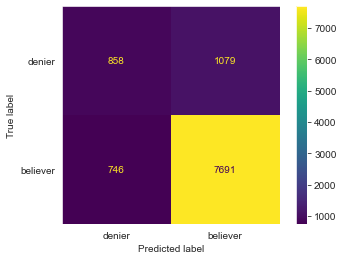

In [32]:
# compare F1 and Accuracy scores for each model
lr1_acc, lr1_f1 = acc_f1('LR1 Val', lr1_val)
lr2_acc, lr2_f1 = acc_f1('LR2 Val', lr2_val)
gbt_acc, gbt_f1 = acc_f1('GBT Val', gbt_val)
lr1_acc, lr1_f1 = acc_f1('RFC Val', rfc_val)

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,14))
plot_conf('LR1 Val', lr1_val, ax[0,0])
plot_conf('LR2 Val', lr2_val, ax[0,1])
plot_conf('GBT Val', gbt_val, ax[1,0])
plot_conf('RFC Val', rfc_val, ax[1,1])

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y, val_predict), display_labels=['denier', 'believer']).plot()
plt.grid(b=None)
plt.show()

## Apply Classifier to remainder dataset

Run the entire dataset through the gridsearch pipeline to make predictions on each tweet

In [33]:
# remove irrelevant response tweets
tweets_final = tweets[tweets['in_reply_to_screen_name'].isna()]

In [34]:
# prepare tweets for model
tweets_final['clean_text'] = tweets_final['full_text'].apply(lambda x: clean_and_lem(x)) 
tweets_final = tweets_final[tweets_final.clean_text.str.strip() != '']
tweets_final = tweets_final[tweets_final.clean_text.str.strip() != ' ']
# run text through model
tweets_final['believer_pred'] = rf_gridsearch.predict(tweets_final['clean_text'])

/Users/browz/opt/anaconda3/envs/ds01/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [35]:
tweets_final['believer_pred'].value_counts(normalize=True)

1.0    0.931688
0.0    0.068312
Name: believer_pred, dtype: float64

In [36]:
# sanity check on predictions
def check_pred(df, n=None):
    if n == None:
        n = np.random.randint(0,len(df)-1)
    print(df.iloc[n]['full_text'], '\n', df.iloc[n]['believer_pred'])
    print(f'https://twitter.com/{df.iloc[n]["screen_names"]}/status/{df.iloc[n]["id"]}')

In [37]:
check_pred(tweets_final[tweets_final['believer_pred']==0])

Ayo Mueller man, where are you? These Hollywood niggas got you looking funny in the light. Pull up! https://t.co/6SrmAvjZbG 
 0.0
https://twitter.com/Lady_RHOalye/status/1026982347487498245


# Sentiment Analysis

In [61]:
def sentiment_score(sentence): 
  
    # Instntiate SentimentIntensityAnalyzer object
    sid_obj = SentimentIntensityAnalyzer() 
  
    # store scoring data in dictionary  
    sentiment_dict = sid_obj.polarity_scores(sentence) 
    
    return sentiment_dict['compound']

In [ ]:
sentiment = X.apply(lambda x: sentiment_score(x))

In [ ]:
sent_df = pd.DataFrame(X)
sent_df = sent_df.assign(target = y)

In [ ]:
sent_df = sent_df.assign(sent = sentiment)

In [ ]:
sent_df.groupby(['target'])['sent'].mean()

In [ ]:
sent_df = sent_df[sent_df['sent'] != 0]
sent_df['sent'] = sent_df['sent'].multiply(100)

In [ ]:
conditions = [sent_df['sent'].isin(range(-100,-50)),
              sent_df['sent'].isin(range(-50, 0)),
              sent_df['sent'].isin(range(0, 50)),
              sent_df['sent'].isin(range(50, 100))]

choices =[-2,-1,0,1]

sent_df['sent_cat'] = np.select(condlist=conditions, choicelist=choices)

In [ ]:
sent_df['sent_cat'].value_counts()

In [ ]:
plt.figure(figsize=(4,3))
sns.countplot(sent_df['sent_cat'])
plt.title('Sentiment for all Tweets')
plt.show()

In [ ]:
grouped_believe = sent_df.groupby(['target', 'sent_cat']).count()
grp_df = pd.DataFrame(grouped_believe)

In [ ]:
grp_df

In [ ]:
pickle_in = open('data/pickle_jar/model.pkl', 'rb')
rf_gridsearch = pickle.load(pickle_in)

In [ ]:
pickle_in.close()